<a href="https://colab.research.google.com/github/harshith7823/CS760-Project/blob/reetu/experiments_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
def preprocess_clinical_data(oppScrData, mean=True):
    clinical_data = oppScrData.filter(['Record ID','BMI','BMI >30', 'Clinical F/U interval  [d from CT]', 'Sex', 'Tobacco', 'Met Sx', 'FRAX 10y Fx Prob (Orange-w/ DXA)',
                                'FRAX 10y Hip Fx Prob (Orange-w/ DXA)','FRS 10-year risk (%)','Age at CT', 'DEATH [d from CT]' ], axis=1)
    # Replace all _,X,blanks with nan
    clinical_data = clinical_data.replace(r'_', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'X', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'^\s*$', np.nan, regex=True)

    # Fill na in bmi column with mean
    clinical_data['BMI'].fillna(value=clinical_data['BMI'].mean(skipna=True), inplace=True)
    
    # Fill na in bmi>30 column based on bmi col
    clinical_data.loc[clinical_data.BMI>30, 'BMI >30'] = 1
    clinical_data.loc[clinical_data.BMI<=30, 'BMI >30'] = -1
    
    clinical_data['Sex'] = np.where(clinical_data['Sex']=='Male',1,-1)
    clinical_data['Met Sx'] = np.where(clinical_data['Met Sx']=='Y',1,-1) 

    # Treat no data in tobacco as no tobacco usage 
    clinical_data['Tobacco'] = np.where(clinical_data['Tobacco']=='Yes',1,-1) 
  
    clinical_data['FRS 10-year risk (%)'] = clinical_data['FRS 10-year risk (%)'].replace("<1", 0.01, regex=True)
    clinical_data['FRS 10-year risk (%)'] = clinical_data['FRS 10-year risk (%)'].replace(">30", 0.30, regex=True)
    clinical_data['FRS 10-year risk (%)'] =  clinical_data['FRS 10-year risk (%)'] * 100
   
    cols_to_be_filled = ['FRAX 10y Fx Prob (Orange-w/ DXA)','FRAX 10y Hip Fx Prob (Orange-w/ DXA)','FRS 10-year risk (%)']
    for c in cols_to_be_filled:
      if mean:  
        clinical_data[c].fillna(value=clinical_data[c].mean(skipna=True), inplace=True)
      else :
        clinical_data[c].fillna(value=clinical_data[c].median(skipna=True), inplace=True)

    clinical_data = fill_death_col(clinical_data)
    return [clinical_data, np.array(clinical_data, dtype=np.float32)]

In [3]:
def clean_ct_data(oppScrData):
    # Delete rows with empty values
    ct_data= oppScrData[["Record ID", "L1_HU_BMD", "TAT Area (cm2)", 'Total Body                Area EA (cm2)',
       'VAT Area (cm2)', 'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'Age at CT']]
    ct_data['Liver HU    (Median)'].replace(' ', np.nan, inplace=True)
    ct_data.dropna(axis = 0, how ='any', thresh = None, subset = None, inplace=True)
    return [ct_data, np.array(ct_data, dtype=np.float32)]

In [4]:
def fill_death_col(clinical_data):
  
  male_obese = (clinical_data['Sex'] == 1) & (clinical_data['BMI'] > 30)
  female_obese = (clinical_data['Sex'] == -1) & (clinical_data['BMI'] > 30)
  male_underweight = (clinical_data['Sex'] == 1) & (clinical_data['BMI'] < 18.5)
  female_underweight = (clinical_data['Sex'] == -1) & (clinical_data['BMI'] < 18.5)
  clinical_data['BMI_reduction_factor'] = 0
  clinical_data.loc[male_obese, 'BMI_reduction_factor'] = 4.2
  clinical_data.loc[female_obese, 'BMI_reduction_factor'] = 3.5
  clinical_data.loc[male_underweight, 'BMI_reduction_factor'] = 4.3
  clinical_data.loc[female_underweight, 'BMI_reduction_factor'] = 4.5

  clinical_data['Tobacco_reduction_factor'] = np.where(clinical_data['Tobacco']==1,10,0)

  
  #Leave na on rows with no death data, fill the rest with age*365+death days 
  # clinical_data['Age_at_death'] = np.where(clinical_data['DEATH [d from CT]'].isna(), np.nan, clinical_data['Age at CT']*365 + clinical_data['DEATH [d from CT]'])
  clinical_data['Age_at_death'] = np.where(clinical_data['DEATH [d from CT]'].isna(), np.nan, clinical_data['Age at CT'] + clinical_data['DEATH [d from CT]']/365)

  # fill death with avg lifespan - alpha(reduction for tobacco) - beta(reduction for bmi)
  corr_bmi_death = clinical_data['BMI'].corr(clinical_data['Age_at_death'])
  corr_tobacco_death = clinical_data['Tobacco'].corr(clinical_data['Age_at_death'])

  # print(corr_bmi_death)
  # print(corr_tobacco_death)

  #normalize
  alpha = corr_bmi_death/(corr_bmi_death+corr_tobacco_death)
  beta = corr_tobacco_death/(corr_bmi_death+corr_tobacco_death)

  # print(alpha)
  # print(beta)
  
  avg_lifespan_male=76.3  
  avg_lifespan_female=81.2

  clinical_data['avg_life'] = np.where(clinical_data['Sex']==1, avg_lifespan_male, avg_lifespan_female)
  clinical_data['avg_life'] = clinical_data['avg_life'] - alpha*(clinical_data['BMI_reduction_factor'])-beta*(clinical_data['Tobacco_reduction_factor'])
  clinical_data['DEATH [d from CT]'].fillna((clinical_data['avg_life']-clinical_data['Age at CT'])*365, inplace=True)
  clinical_data['Age_at_death'].fillna(clinical_data['Age at CT'] + clinical_data['DEATH [d from CT]']/365, inplace=True)
  # clinical_data.drop(columns=['Age_at_death'], inplace=True) #only used for correlation, we dont need this any further
  return clinical_data


In [7]:
oppScrData = pd.read_excel (r'sample_data/OppScrData.xlsx') 

In [8]:
clinical_data, clinical_data_np = preprocess_clinical_data(oppScrData)
ct_data, ct_data_np = clean_ct_data(oppScrData)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [32]:
combined_data = clinical_data.merge(ct_data, on='Record ID', how='inner' )
combined_data.drop(columns=['DEATH [d from CT]', 'Record ID'], inplace=True)
# print(clinical_data['Age_at_death'])
# data_for_corr = combined_data.drop(columns=['Record ID','Tobacco','DEATH [d from CT]','BMI >30','Age at CT_x', 'Age at CT_y'])
print(combined_data.columns)

Index(['BMI', 'BMI >30', 'Clinical F/U interval  [d from CT]', 'Sex',
       'Tobacco', 'Met Sx', 'FRAX 10y Fx Prob (Orange-w/ DXA)',
       'FRAX 10y Hip Fx Prob (Orange-w/ DXA)', 'FRS 10-year risk (%)',
       'Age at CT_x', 'BMI_reduction_factor', 'Tobacco_reduction_factor',
       'Age_at_death', 'avg_life', 'L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'Age at CT_y'],
      dtype='object')


In [33]:
print(combined_data.shape)

(8878, 26)


In [11]:
selected_rows = combined_data[~combined_data['Age_at_death'].isnull()]
print(selected_rows.shape)

(8878, 27)


In [34]:
print(selected_rows['Age_at_death'].head)

<bound method NDFrame.head of 0       55.983562
1       81.200000
2       66.441096
3       89.802740
4       75.120198
          ...    
8873    76.300000
8874    75.120198
8875    78.112931
8876    81.200000
8877    76.300000
Name: Age_at_death, Length: 8878, dtype: float64>


In [28]:
# make a regression prediction with an RFE pipeline
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, ElasticNet,RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

def testWithModel(model):
  y = np.array(selected_rows['Age_at_death'])
  X = np.array(selected_rows.drop(columns=['Age_at_death']))

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
  regr = model
  regr.fit(X_train, y_train)
  y_hat = regr.predict(X_test)

  print(mean_absolute_error(y_test, y_hat))
  plot_results(y_test, y_hat)


SVR
1.7881710562757127


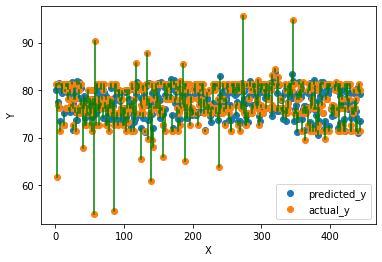

Lasso
1.1189897184927569


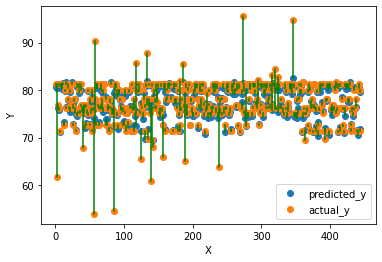

Elastic
1.200777970441241


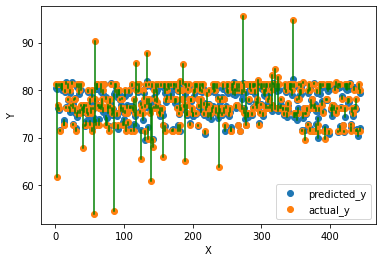

Decision Tree Regressor
1.0360715421112583


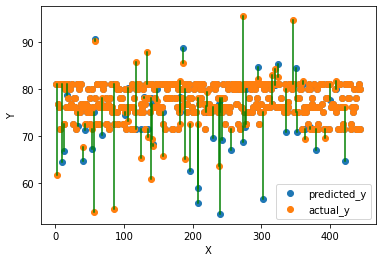

Ridge
1.0779955753234054


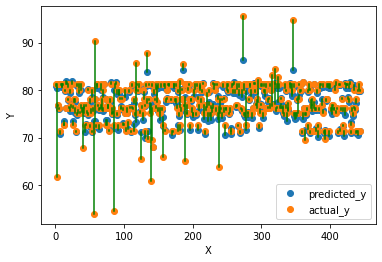

KNNRegressor
2.855034040797776


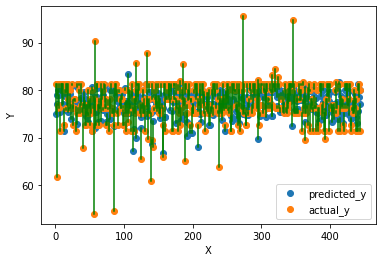

In [29]:
print('SVR')
testWithModel(SVR(C=300, epsilon=0.02)) # uses RBF kernel by default
print('Lasso')
testWithModel(Lasso(alpha=0.5))
print('Elastic')
testWithModel(ElasticNet(random_state=0))
print('Decision Tree Regressor')
testWithModel(DecisionTreeRegressor(criterion="absolute_error"))
print('Ridge')
testWithModel(RidgeCV())
print("KNNRegressor")
testWithModel(KNeighborsRegressor())

In [30]:
print(selected_rows.columns)


Index(['Record ID', 'BMI', 'BMI >30', 'Clinical F/U interval  [d from CT]',
       'Sex', 'Tobacco', 'Met Sx', 'FRAX 10y Fx Prob (Orange-w/ DXA)',
       'FRAX 10y Hip Fx Prob (Orange-w/ DXA)', 'FRS 10-year risk (%)',
       'Age at CT_x', 'BMI_reduction_factor', 'Tobacco_reduction_factor',
       'Age_at_death', 'avg_life', 'L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'Age at CT_y'],
      dtype='object')


In [16]:
import matplotlib.pyplot as plt

def plot_results(y_test, y_hat):
  plt.figure()
  x = [i+1 for i in range(len(y_test))]
  plt.plot((x,x),([i for i in y_hat], [j for j in y_test]),c='green')
  plt.scatter(x, y_hat, label="predicted_y")
  plt.scatter(x, y_test, label="actual_y")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.legend()
  plt.show()

In [15]:
import math
def mean_absolute_error(actual, predictions):
  n = len(actual)
  return np.sum(abs(np.subtract(actual, predictions)))/n

def root_mean_squared_error(actual, predictions):
  n = len(actual)
  se = sum((actual - predictions)**2)
  return math.sqrt(se/n)

def mean_absolute_percentage_error(actual, predictions):
  n = len(actual)
  return sum((actual - predictions)/actual)/n

def avg_error_for_np_arr(actual_np, pred_np):
  sum=0
  for i, _ in enumerate(pred_np):
    val = pred_np[i]-actual_np[i]
    if(val<0):
      val=-val
    sum+=val
  return(sum/len(pred_np))
  
def print_errors(y_test, predicted_y):
  print(mean_absolute_error(y_test, predicted_y))
  print(root_mean_squared_error(y_test, predicted_y))
  print(mean_absolute_percentage_error(y_test, predicted_y))